(sec-convolution)=
# Convolution

In [1]:
import numpy as np
import scipy.integrate as integrate
import scipy.special as special
from scipy.integrate import quad
import matplotlib.pyplot as plt
import scipy.special
import seaborn as sns
from scipy.integrate import cumtrapz

dpi = 300
transparent = True
PI = np.pi
TWO_PI = 2*PI
NUM = 44000
show = False

sns.set_theme('paper')
sns.set_style("whitegrid")

Convolution is an operation that takes two functions and outputs a new function.
In that sense, it is very similar to addition or multiplication.
Given two function $y_1, y_2$ we can compute a new function

$$y_3(t) = (y_1 \cdot y_2)(t) = y_1(t) \cdot y_2(t).$$

The same is true for the convolution of these two functions:

$$y_3(t) = (y_1 * y_2)(t).$$

But what does the *convolution operator* $*$ really do?

(sec-discrete-convolution)=
## Discrete Convolution

Let us start with two arrays of numbers which represent discrete functions $y_1, y_2$.

We can use component-wise multiplication to generate a new function:

```isc
[1,2,3,4] * [-1,3,-1,3] // [ -1, 6, -3, 12 ], y_1[k] * y_2[k]
```

In that case,

$$y_3[k] = y_1[k] \cdot y_2[k].$$

The convolution is defined very differently.
The idea is to mirrow the second function and to compute the weighted sum of a sliding window.

```{figure} ../../../figs/sounddesign/math/array_conv.png
---
width: 900px
name: fig-array-conv
---
Visualization of the computation of a convolution of two discrete signals (arrays of numbers).
```

Given $y_1 = [1,2,3,4]$ and $y_2 = [ -1, 6, -3, 1]$, we use sliding window to compute the new function by a weighted sum.

\begin{equation*}
\begin{split}
y[-3] &= -1 \cdot 1 &= -1 \\
y[-2] &= -1 \cdot 2 + 3 \cdot 1 &= 1 \\
y[-1] &= -1 \cdot 3 + 3 \cdot 2 - 1 \cdot 1 &= 2 \\
y[+0] &= -1 \cdot 4 + 3 \cdot 3 - 1 \cdot 2 + 3 \cdot 1 &= 6 \\
y[+1] &= +3 \cdot 4 -1 \cdot 3 + 3 \cdot 2 &= 15\\
y[+2] &= -1 \cdot 4 + 3 \cdot 3 &= 5 \\
y[+3] &= +3 \cdot 4 &= 12
\end{split}
\end{equation*}

Interestingly, the lengths of the signals do not have to match, and the new length of the new signal is equal to the sum of the length of the original signals minus 2.

The following ``sclang`` function computes the convolution of two discrete function:

```isc
(
~convolve = {arg a, b;
    var a_pad, b_pad, result, val;

    a_pad = Array.fill(b.size-1, 0) ++ a;
    b_pad = b.reverse ++ Array.fill(a.size-1, 0);

    result = [];
    for(0, a.size+b.size-2, {
        val = (a_pad * b_pad).sum;
        result = result ++ [val];
        b_pad = b_pad.rotate(1);
    });
    result;
};
)

~convolve.([1,2,3,4], [-1,3,-1,3]); // [ -1, 1, 2, 6, 15, 5, 12 ]
```

````{admonition} Convolution of Discrete Signals
:name: def-discrete-convolution
:class: definition

Given two discrete and finite signals $y_1, y_2 : \mathbb{N} \rightarrow \mathbb{R}$ of length $N_1$ and $N_2$ respectively. Then the convolution of those two singals is defined by

\begin{equation}
(y_1 * y_2)[n] = y[n] = \sum\limits_{k=0, n-k\geq 0}^{N_1} y_1[k] \cdot y_2[n-k],
\end{equation}

where $y: \{0, \ldots, N_1 + N_2 - 2\} \rightarrow \mathbb{R}$.
````

Since we are most interested in peridic functions, a more useful definition is given by the *circular discrete convolution*.
In that case, we $y_2$ to be $N_2$-periodic.

````{admonition} Circular Discrete Convolution
:name: def-circular-discrete-convolution
:class: definition

Given two discrete signals $y_1, y_2$, where $y_1$ is defined for $0, \ldots N-1$ and $y_2$ is a periodic function with period equal to $N_2$. Then the circular convolution of those two singals is defined by

\begin{equation}
(y_1 * y_2)[n] = y[n] = \sum\limits_{k=0}^{N-1} y_1[k] \cdot y_2[n-k],
\end{equation}

where $y : \mathbb{Z} \rightarrow \mathbb{R}$ is periodic.
````

```{figure} ../../../figs/sounddesign/math/array_conv_periodic.png
---
width: 900px
name: fig-array-conv-periodic
---
Visualization of the computation of a convalution of two discrete signals (arrays of numbers) where the second is (infinite) and periodic.
```

The circular convolution of a finite signal with a infinite periodic discrete function is an infinite periodic funciton.
This in our code we do not construct an ``Array`` but a new function.

```isc
(
~cconvolve = {arg a, b;
    var func = {arg n;
        (a *.s (b.reverse.rotate).rotate(n)).sum;
    };
    func;
};
f = ~cconvolve.([1,2,3,4], [-1,3,-1,3]);
y = Array.fill(12, {arg i; f.(i);});
y // [ 14, 6, 14, 6, 14, 6, 14, 6, 14, 6, 14, 6 ]
)
```

The ``sclang`` code is relatively short.
``cconvolve`` returns the function, i.e., $y$, based on the two arrays, but here we assume the second one is circular.
Since our second array has a period of 2, the resulting signal $y$ also has a period of 2.

Note that the convolution is like multiplying two functions, but one is mirrored and shifted.
$(y_1 \cdot y_2)[n]$ is positive if the two functions are either both positive or both negative at $n$.
Therefore, if $y_1, y_2$ are periodic functions with DC = 0, $(y_1 \cdot y_2)(t)$ says something about their similarity, see section [Similarity of Periodic Functions](sec-similarity-of-functions).

Since the convolution is the sum of these similarity measures, it tells us something about the similarity of the two functions too.
In our example, we can see that $y_2$ mirrored is most similar if it is not shifted.
The argument $n$ of $(y_1 * y_2)[n]$ defines the shift of the second function, which determines the **phase** if we are in the domain of periodic functions!

If both signals are discrete but infinite (and defined on $\mathbb{Z}$), the discrete convolution of $y_1, y_2$ is given by:

\begin{equation}
(y_1 * y_2)[n] = \sum\limits_{k=-\infty}^{\infty} y_1[k] \cdot y_2[n-k] = \sum\limits_{k=-\infty}^{\infty} y_1[n-k] \cdot y_2[k].
\end{equation}

## Continuous Convolution

If $y_1, y_2$ are continuous functions then the sum becomes an integral.

````{admonition} Convolution
:name: def-convolution
:class: definition

Given two functions $y_1, y_2 : \mathbb{R} \rightarrow \mathbb{R}$ then the *convolution* is defined by 

\begin{equation}
(y_1 * y_2)(t) = y(t) = \int_{-\infty}^{\infty} y_1(\tau) \cdot y_2(t-\tau) d\tau,
\end{equation}
````

This looks intimidating but there is nothing to fear.
Instead of a sum over an index $k$ we have the integration over $\tau$ and $t$ represents the shift of our second (mirrored) funciton.

## Rules

Imagine the function $y$ which is 1 between 0 and 1 and zero elsewhere.
$y$ represents a square.
Consequently, $(y * y)$ represents the overlapping area of two squares.
Since the second square is mirrored at the y-axis, $(y * y)(t) = 0$ for $t=0$.
However, if we increase $t$, $(y * y)$ increases linearly until it reaches its maximum at $(y * y)(1) = 1$.
Then it decreases again.
Therefore, $(y * y)(t)$ is a triangle!

Let us illustrate some more examples.
In the following plot each row represents one convolution.
In the first and second column you find the functions $y_1, y_2$ and in the third column the plot shows $y_1 * y_2$.

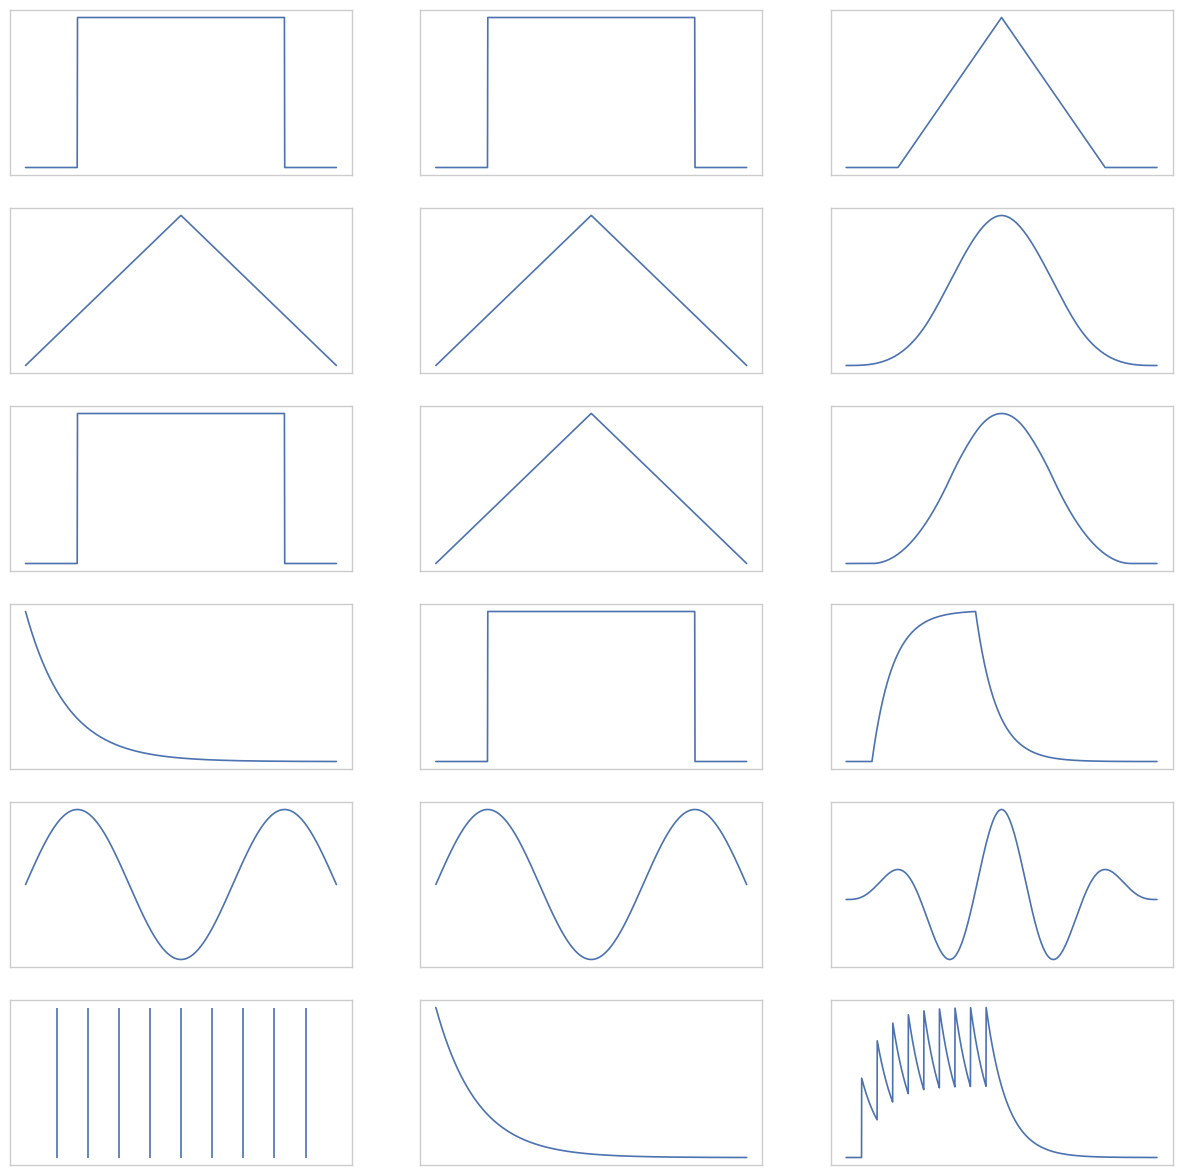

In [2]:
x = np.linspace(0, 1.5, 1000)
xp = np.linspace(0, 1.5, 1000*2-1)

rect = lambda x: 1 if 0.25 < x < 1.25 else 0
tri = lambda x: (-np.abs(x-0.75)+0.75)*(1/0.75)
exp_dec = lambda x: np.exp(-5*x)
sine = lambda x: np.sin(2*np.pi*x)
impulse = np.zeros(len(x))

for i in range(100, 1000, 100):
    impulse[i] = 1

nrows = 6
ncols = 3

fig, ax = plt.subplots(figsize=(15,nrows*2.5), nrows = nrows, ncols = 3)

y = np.array([rect(val) for val in x])

ax[0][0].plot(x, y)
ax[0][1].plot(x, y)
ax[0][2].plot(xp, np.convolve(y, y)/(len(y)/1.5))

y = np.array([tri(val) for val in x])

ax[1][0].plot(x, y)
ax[1][1].plot(x, y)
ax[1][2].plot(xp, np.convolve(y, y)/(len(y)))

y1 = np.array([rect(val) for val in x])
y2 = np.array([tri(val) for val in x])

ax[2][0].plot(x, y1)
ax[2][1].plot(x, y2)
ax[2][2].plot(xp, np.convolve(y1, y2)/(len(y)/1.5))


y1 = np.array([exp_dec(val) for val in x])
y2 = np.array([rect(val) for val in x])

ax[3][0].plot(x, y1)
ax[3][1].plot(x, y2)
ax[3][2].plot(xp, np.convolve(y1, y2))


y1 = np.array([sine(val) for val in x])
y2 = np.array([sine(val) for val in x])

ax[4][0].plot(x, y1)
ax[4][1].plot(x, y2)
ax[4][2].plot(xp, np.convolve(y1, y2))


y1 = impulse
y2 = np.array([exp_dec(val) for val in x])

ax[5][0].stem(x, y1, linefmt='-', markerfmt=' ', basefmt=' ')
ax[5][1].plot(x, y2)
ax[5][2].plot(xp, np.convolve(y1, y2));

for row in range(nrows):
    for col in range(ncols):
        ax[row][col].set_xticks([])
        ax[row][col].set_yticks([]);

The plots show us some effects of the convolution:

1. Convolving a function $y$ with an impulse function just copies $y$.
2. Convolving $y$ with a shifted impulse function makes a shifted copy of $y$.
3. Convolving $y$ with a scaled impulse function scales $y$.
4. Convilving $y$ with a scaled, shifted impulse function scales and shifts $y$.
5. Convolving with an *impulse train*such (last row) adds a shifted original to the output for each impulse.
6. As many copies will be superimposed as there are nonzero impulses.
7. Copies will be shifted (delayed) by the position of the impulse in the *impulse train* function.
8. Shifted copies will be scaled by the amplitude of the impulses.
9. Shifted, scaled copies of the original are summed, smearing the result.

```{admonition} Convolution Theorem
:name: theorem-fourier-convolution
:class: theorem

Let $y_1, y_2$ be two functions for which we can comupte the respective [Fourier transform](def-fourier-transform-exp) $Y_1 = \mathcal{F}\{y_1\}$, and $Y_2 = \mathcal{F}\{y_2\}$ respectively.
Then

$$(y_1 * y_2)(t) = \mathcal{F}^{-1}\{Y_1 \cdot Y_2\}(t)$$

and 

$$(y_1 \cdot y_2)(t) = \mathcal{F}^{-1}\{Y_1 * Y_2\}(t)$$

```

Multiplying in the time domain convolves in the frequency domain and multiplying in the frequency domain convolves in the time domain.
Therefore, to compute the convolution one can do so by compute the [Fouier tranform](def-fourier-transform-exp) beforehand.
In fact, this is how the unit generators, such as [Convolution](https://doc.sccode.org/Classes/Convolution.html), are implemented.

## The Convolution Unit Generator

We can compute a discrete convolution on the audio server using the [Convolution](https://doc.sccode.org/Classes/Convolution.html) unit generator.
Let's try to contruct a triangle wave by convoluting two pulse waves.

```isc
({
    var n, sig;
    n = 512;
    sig = LFPulse.ar(s.sampleRate/n);
    sig = Convolution.ar(sig, sig, 2*n) * n.reciprocal;
    sig
}.plot(512*5/s.sampleRate);
)
```

```{figure} ../../../figs/sounddesign/math/sc-convolution-pulse.png
---
width: 400px
name: fig-sc-convolution-pulse
---
Convoluting two pulse waves results in a triangle wave.
```

As you can see, we get the expected result!

```isc
({
    var n, sig, kernel;
    n = 512;
    sig = LFSaw.ar(s.sampleRate/n);
    kernel = LFSaw.ar(s.sampleRate/n);
    sig = Convolution.ar(sig, kernel, 2*n) * n.reciprocal;
    sig
}.plot(512*5/s.sampleRate);
)
```

```{figure} ../../../figs/sounddesign/math/sc-convolution-saw.png
---
width: 400px
name: fig-sc-convolution-saw
---
Convoluting two sawtooth waves results in parabola-like wave.
```

To compute ‘perfect’ convolution in the time domain, one requires all function values beforehand. 
This would make real-time processing impossible! Therefore, [Convolution](https://doc.sccode.org/Classes/Convolution.html) computes a windowed Fourier transform, i.e., the [Fouier tranform](def-fourier-transform-exp) of a short snipped of the functions (in and the kernel). 
Based on that, it computes the convolution of those snippets. To do so, the unit generator has to fill a buffer of a specific size (twice the number of framesize). 
Before the convolution can start, the buffer has to be filled; therefore, the result is zero at the beginning.
The larger the buffer, the more expensive the operation gets and the more zeros there are at the beginning. 
If one period of the signals fits approximately into the buffer, the result will look approximately similar to a ‘perfect’ convolution.